In [44]:
!pip install -U pydicom
!pip install albumentations
!pip install monai

In [45]:
# Libraries
import os
import re
import gc
import cv2
import wandb
import PIL
from PIL import Image
from sklearn.metrics import classification_report
import random
import math
import shutil
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import warnings
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# .dcm handling
import pydicom
# import nibabel as nib
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Environment check
warnings.filterwarnings("ignore")

In [46]:
# PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import torchvision 
import torchvision.transforms as transforms
# from warmup_scheduler import GradualWarmupScheduler
import albumentations

from sklearn.model_selection import GroupKFold, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix

# MONAI 3D
from monai.transforms import Randomizable, apply_transform
from monai.transforms import Compose, Resize, ScaleIntensity, ToTensor, RandAffine, RandRotate
from monai.networks.nets import densenet

In [47]:
def read_data():
    '''Reads in all .csv files.'''
    
    train = pd.read_csv(f"{INPUT}/train.csv")
    train_bbox = pd.read_csv(f"{INPUT}/train_bounding_boxes.csv")
    test = pd.read_csv(f"{INPUT}//test.csv")
    # ss = pd.read_csv(f"{INPUT}//sample_submission.csv")
    
    return train, train_bbox, test#, ss

def get_csv_info(csv, name="Default"):
    '''Prints main information for the speciffied .csv file.'''
    
    print(f"=== {name} ===")
    print(f"Shape:", csv.shape)
    print(f"Missing Values:", csv.isna().sum().sum(), "total missing datapoints.")
    print("Columns:", list(csv.columns), "\n")
    
    display_html(csv.head())
    print("\n")
    
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [48]:
# Environment check
warnings.filterwarnings("ignore")
# os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_SpineFracture', '_wandb_kernel': 'aot'}

# set seed
set_seed(0)

# set GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# Kaggle Notebook Setup
DF_SIZE = 0.01
N_SPLITS = 5
KERNEL_TYPE = 'densenet121_baseline'
IMG_RESIZE = 100
STACK_RESIZE = 50
use_amp = False
NUM_WORKERS = 1
BATCH_SIZE = 2
LR = 0.05
OUT_DIM = 8
EPOCHS = 2

target_cols = ['C1', 'C2', 'C3', 
               'C4', 'C5', 'C6', 'C7',
               'patient_overall']

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=DEVICE),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=DEVICE),
}

INPUT = "../input/rsna-2022-cervical-spine-fracture-detection"
CHECKPOINT_PATH='./densenet121_baseline_best_fold0_2a1ca668-540d-11ed-abb4-aa0cb2e0f96a.pth'

Device: cuda


In [49]:
train, train_bbox, test_df = read_data()

In [50]:
# only use known val data
train = train[train.StudyInstanceUID.isin(['1.2.826.0.1.3680043.21561', '1.2.826.0.1.3680043.5565',
       '1.2.826.0.1.3680043.20509', '1.2.826.0.1.3680043.23355',
       '1.2.826.0.1.3680043.10732', '1.2.826.0.1.3680043.4167',
       '1.2.826.0.1.3680043.7673', '1.2.826.0.1.3680043.581',
       '1.2.826.0.1.3680043.9548', '1.2.826.0.1.3680043.5126',
       '1.2.826.0.1.3680043.31569', '1.2.826.0.1.3680043.17325',
       '1.2.826.0.1.3680043.12182', '1.2.826.0.1.3680043.27282',
       '1.2.826.0.1.3680043.3397', '1.2.826.0.1.3680043.3020',
       '1.2.826.0.1.3680043.22276', '1.2.826.0.1.3680043.19947',
       '1.2.826.0.1.3680043.8939', '1.2.826.0.1.3680043.9811',
       '1.2.826.0.1.3680043.30831', '1.2.826.0.1.3680043.16463',
       '1.2.826.0.1.3680043.22711', '1.2.826.0.1.3680043.23904',
       '1.2.826.0.1.3680043.26791', '1.2.826.0.1.3680043.10041',
       '1.2.826.0.1.3680043.12675', '1.2.826.0.1.3680043.27714',
       '1.2.826.0.1.3680043.21978', '1.2.826.0.1.3680043.17625',
       '1.2.826.0.1.3680043.18207', '1.2.826.0.1.3680043.11757',
       '1.2.826.0.1.3680043.10204', '1.2.826.0.1.3680043.2595',
       '1.2.826.0.1.3680043.24974', '1.2.826.0.1.3680043.8385',
       '1.2.826.0.1.3680043.14087', '1.2.826.0.1.3680043.19084',
       '1.2.826.0.1.3680043.29876', '1.2.826.0.1.3680043.4678',
       '1.2.826.0.1.3680043.15253'])]

In [51]:
# test RSNA dataset

class RSNADataset_test(Dataset, Randomizable):
    
    def __init__(self, csv, mode, transform=None):
        self.csv = csv
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return self.csv.shape[0]
    
    def randomize(self) -> None:
        '''-> None is a type annotation for the function that states 
        that this function returns None.'''
        
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self.seed = self.R.randint(MAX_SEED, dtype="uint32")
        
    def __getitem__(self, index):
        # Set Random Seed
        self.randomize()
        
        dt = self.csv.iloc[index, :]
        study_paths = glob(f"{INPUT}/train_images/{dt.StudyInstanceUID}/*")
        study_paths.sort(key=natural_keys)
        
        # Load images
        study_images = [cv2.imread(path)[:,:,::-1] for path in study_paths]
        # Stack all scans into 1
        stacked_image = np.stack([img.astype(np.float32) for img in study_images], 
                                 axis=2).transpose(3,0,1,2)
        
        # Apply transforms
        if self.transform:
            if isinstance(self.transform, Randomizable):
                self.transform.set_random_state(seed=self.seed)
                
            stacked_image = apply_transform(self.transform, stacked_image)
        
        # Determine output of dataset
        if self.mode=="test":
            return {"image": stacked_image,
                   "patient":dt.StudyInstanceUID}
        else:
            targets = torch.tensor(dt[target_cols]).float()
            return {"image": stacked_image,
                    "targets": targets}

In [44]:
import pandas as pd
model_results = pd.read_csv(f'./{CHECKPOINT_PATH[2:-4]}_train_results.csv')

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
pd.set_option("mode.chained_assignment", None)
from pprint import pprint

In [66]:
def define_eval_metrics(df,verbose = False):
    cls_report = classification_report(y_true=df.actual, y_pred = df.fractured, zero_division=0, output_dict=True)

    recall = cls_report['1']['recall']
    precision = cls_report['1']['precision']

    tn, fp, fn, tp = confusion_matrix(y_true=df.actual, y_pred = df.fractured).ravel()

    fpr = fp / (fp+tn)
    fnr = fn / (fn+tp)

    pred_pos_rate = np.mean(df.fractured == 1)
    actual_pos_rate = np.mean(df.actual == 1)

    if verbose:

        print('\nClassification Report')
        pprint(cls_report)

        print(f"""
        TN: {tn}
        FP: {fp}
        FN: {fn}
        TP: {tp}
        """)

        # print FPR and FNR
        print(f"FPR: {fpr :.4}")
        print(f"FNR: {fnr :.4}")

        # value count + value count normalized for predictions.
        print('Number of fractured vs non-fractured predictions')
        print(df.fractured.value_counts())
        print('Ratio of fractured vs non-fractured predictions')
        print(df.fractured.value_counts(normalize=True))

        # What is the predicted positive fracture rate compared to the actual?
        print(f"""
        Predicted positive fracture rate: {np.round(pred_pos_rate,4)}
        Actual fracture rate {np.round(actual_pos_rate,4)}"""
        )
    
    return([recall,precision,tn,fp,fn,tp,fpr,fnr])

def eval_model(df):
    
    try:
        print(f'Average inference time : {inference_time/(len(df)/8):.3f} s per patient')
    except:
        print('No time data available')

    # initialize patient and vertebrae df
    df['fractured'] = round(df.fractured)
    patient_df = df[df.row_id.str.contains("patient_overall")]
    vert_df =  df[~df.row_id.str.contains("patient_overall")]

    # store eval metrics
    eval_metrics = dict()
    eval_metrics['eval_metric'] = ['recall','precision','tn','fp','fn','tp','fpr','fnr']

    eval_metrics['patient_level'] = define_eval_metrics(patient_df)
    eval_metrics['vertebrae_level'] = define_eval_metrics(vert_df)
    
    # which vertebrae are missed the most? FP FN?
    vert_df.loc[:,'vertebrae'] = vert_df.row_id.str.split('_',).apply(lambda x: x[-1])

    for vertebra in vert_df.vertebrae.unique():
        eval_metrics[vertebra] = define_eval_metrics(
            vert_df.loc[vert_df.vertebrae == vertebra])

    
    # issues with patient overall not match patient vertebrae prediction?
    
    return(pd.DataFrame.from_dict(eval_metrics))


In [67]:
model_results_tbl = eval_model(model_results)

Average inference time : 5.261 s per patient
****************** Evaluating model at patient-level ******************
****************** Evaluating model at vertebrae-level ******************
****************** C1 ******************
****************** C2 ******************
****************** C3 ******************
****************** C4 ******************
****************** C5 ******************
****************** C6 ******************
****************** C7 ******************


In [68]:
model_results_tbl[['patient_level', 'vertebrae_level', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7']] = model_results_tbl[['patient_level', 'vertebrae_level', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7']].applymap(lambda x: np.round(x,3))

In [69]:
model_results_tbl

,eval_metric,patient_level,vertebrae_level,C1,C2,C3,C4,C5,C6,C7
0,recall,0.0,0.086,0.0,0.0,0.333,1.000,0.0,0.0,0.0
1,precision,0.0,0.073,0.0,0.0,0.037,0.143,0.0,0.0,0.0
2,tn,19.0,214.000,37.0,33.0,12.000,27.000,36.0,36.0,33.0
3,fp,0.0,38.000,0.0,0.0,26.000,12.000,0.0,0.0,0.0
4,fn,22.0,32.000,4.0,8.0,2.000,0.000,5.0,5.0,8.0
5,tp,0.0,3.000,0.0,0.0,1.000,2.000,0.0,0.0,0.0
6,fpr,0.0,0.151,0.0,0.0,0.684,0.308,0.0,0.0,0.0
7,fnr,1.0,0.914,1.0,1.0,0.667,0.000,1.0,1.0,1.0


In [61]:
model_results[model_results.actual - model_results.fractured == 1].head()

,actual,row_id,fractured
0,1,1.2.826.0.1.3680043.21561_patient_overall,0.0
4,1,1.2.826.0.1.3680043.10732_patient_overall,0.0
7,1,1.2.826.0.1.3680043.581_patient_overall,0.0
11,1,1.2.826.0.1.3680043.17325_patient_overall,0.0
13,1,1.2.826.0.1.3680043.27282_patient_overall,0.0


In [ ]:
patient_id = '1.2.826.0.1.3680043.581'
model_results[model_results.row_id.str.startswith(patient_id)]

,actual,row_id,fractured
7,1,1.2.826.0.1.3680043.581_patient_overall,0.0
48,1,1.2.826.0.1.3680043.581_C1,0.0
89,1,1.2.826.0.1.3680043.581_C2,0.0
130,0,1.2.826.0.1.3680043.581_C3,1.0
171,0,1.2.826.0.1.3680043.581_C4,0.0
212,0,1.2.826.0.1.3680043.581_C5,0.0
253,0,1.2.826.0.1.3680043.581_C6,0.0
294,0,1.2.826.0.1.3680043.581_C7,0.0


In [ ]:
model_results_vert = model_results[~model_results.row_id.str.contains('patient_overall')].copy()
model_results_vert['vertebrae'] = model_results_vert.row_id.apply(lambda x: x.split('_')[-1])


model_results_vert['actual_vertebrae'] = NULL
model_results_vert['predicted_vertebrae'] = NULL
model_results_vert.loc[model_results_vert['actual'] == 1, 'actual_vertebrae'] = model_results_vert.loc[model_results_vert['actual'] == 1, 'vertebrae']
model_results_vert.loc[model_results_vert['fractured'] == 1, 'predicted_vertebrae'] = model_results_vert.loc[model_results_vert['fractured'] == 1, 'vertebrae']

In [ ]:
model_results_vert[['actual_vertebrae','predicted_vertebrae']].value_counts()

In [52]:
# send the data to GPU
def data_to_device(data):
    image, patient = data.values()
    return image.to(DEVICE), patient

In [53]:
# transform
test_transforms = Compose([ScaleIntensity(), 
                          Resize((IMG_RESIZE, IMG_RESIZE, STACK_RESIZE)), 
                          RandRotate(range_x=45, range_y=45),
                          ToTensor()])

In [54]:
# Instantiate Dataset object
test_dataset = RSNADataset_test(csv=train, mode="test", transform=test_transforms)
# The Dataloader
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)

# Load trained model

In [55]:
model = densenet.densenet121(spatial_dims=3, in_channels=3,
                                 out_channels=OUT_DIM)
model.class_layers.out = nn.Sequential(nn.Linear(in_features=1024, out_features=OUT_DIM), 
                                           nn.Softmax(dim=1))
model.to(DEVICE)

DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [56]:
%%capture
# Load checkpoint
if torch.cuda.is_available():
    checkpoint = torch.load(CHECKPOINT_PATH)
else:
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# Load states
model.load_state_dict(checkpoint)

# Evaluation mode
model.eval()
model.to(DEVICE)

# Inference

In [57]:
test_preds = []
t0 = time()
for i, data in enumerate(test_dataloader):
        print(f'Iteration {i+1}/{len(test_dataloader)}')
        # Send to device
        imgs, patient = data_to_device(data)
        
        # Make predictions
        preds = model(imgs)
        
        # output to device
        test_preds.append(preds.detach().cpu().numpy())
        
tf = time()
inference_time = tf-t0
print(f"""
    Inference time = {inference_time/3600} hrs
    Number of predictions = {train.StudyInstanceUID.nunique()}
    """)

[2022-11-01 23:28:38.303 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:23 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-01 23:28:38.439 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:23 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Iteration 1/14
Iteration 2/14
Iteration 3/14
Iteration 4/14
Iteration 5/14
Iteration 6/14
Iteration 7/14
Iteration 8/14
Iteration 9/14
Iteration 10/14
Iteration 11/14
Iteration 12/14
Iteration 13/14
Iteration 14/14

    Inference time = 0.09169739915264977 hrs
    Number of predictions = 41
    


In [58]:
preds = []
for i in test_preds:
    for j in i:
        preds.append(j)

## Process predictions

In [59]:
def process_test(df, preds):
    cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'patient_overall']
    patients = df.StudyInstanceUID.to_list()
    
    df_sub = pd.DataFrame()
    
    for i, p in enumerate(patients):
        scores = list(preds[i])
        if len(scores) < 8:
            scores.append(preds[i].max() + preds[i].mean())
        
        df_temp = pd.DataFrame({'StudyInstanceUID': [p]*len(cols), 'prediction_type': cols, 'fractured': scores})
        df_sub = pd.concat([df_sub, df_temp])
        
        del df_temp
    
    df_sub['row_id'] = df_sub['StudyInstanceUID'] + '_' + df_sub['prediction_type']
    
    return df_sub[['row_id', 'fractured']].reset_index(drop = True)
    

In [60]:
df_sub = process_test(train,preds)

In [61]:
train_melt = pd.melt(train,
                     id_vars=['StudyInstanceUID'],
                     value_vars = ['patient_overall','C1','C2','C3','C4','C5','C6','C7'],
                     value_name = 'actual',
                    )
train_melt['row_id'] = train_melt['StudyInstanceUID'] + '_' + train_melt['variable']
train_melt = train_melt.drop(columns = ['StudyInstanceUID','variable'])

In [62]:
model_results = pd.merge(train_melt,df_sub, on ='row_id',how='outer')
model_results.head()

,actual,row_id,fractured
0,1,1.2.826.0.1.3680043.21561_patient_overall,0.000000e+00
1,0,1.2.826.0.1.3680043.5565_patient_overall,0.000000e+00
2,0,1.2.826.0.1.3680043.20509_patient_overall,8.332293e-08
3,0,1.2.826.0.1.3680043.23355_patient_overall,0.000000e+00
4,1,1.2.826.0.1.3680043.10732_patient_overall,0.000000e+00


In [63]:
model_results.to_csv(f"{CHECKPOINT_PATH[2:-4]}_train_results_tilted.csv",index=False)

No time data available


,eval_metric,patient_level,vertebrae_level,C1,C2,C3,C4,C5,C6,C7
0,recall,0.00%,6.00%,0.00%,0.00%,33.00%,50.00%,0.00%,0.00%,0.00%
1,precision,0.00%,5.00%,0.00%,0.00%,4.00%,8.00%,0.00%,0.00%,0.00%
2,tn,19,213,37,33,11,27,36,36,33
3,fp,0,39,0,0,27,12,0,0,0
4,fn,22,33,4,8,2,1,5,5,8
5,tp,0,2,0,0,1,1,0,0,0
6,fpr,0.00%,0.15%,0.00%,0.00%,0.71%,0.31%,0.00%,0.00%,0.00%
7,fnr,1.00%,0.94%,1.00%,1.00%,0.67%,0.50%,1.00%,1.00%,1.00%


actual_vertebrae  predicted_vertebrae
NaN               C3                     31.71%
                  C4                     14.63%
C1,C2             C3                      7.32%
C2                C3                      7.32%
C7                C4                      7.32%
C6,C7             C3                      4.88%
C7                C3                      4.88%
C1                C3                      2.44%
C2                C4                      2.44%
C2,C3,C5          C4                      2.44%
C3                C3                      2.44%
C3,C4,C5,C6       C4                      2.44%
C4,C5             C3                      2.44%
C5                C3                      2.44%
C5,C6,C7          C3                      2.44%
C6                C4                      2.44%
dtype: object

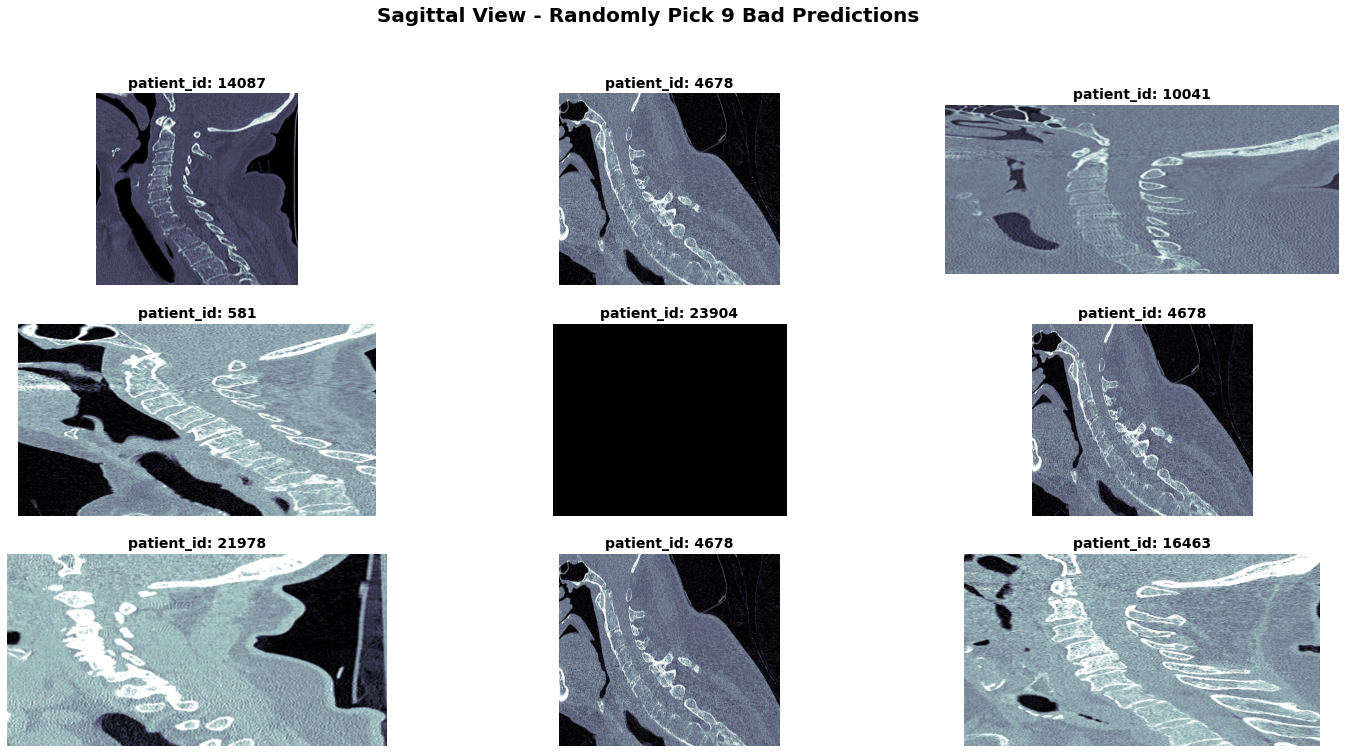

In [52]:
import error_helper

CHECKPOINT_PATH='./densenet121_baseline_best_fold0_2a1ca668-540d-11ed-abb4-aa0cb2e0f96a.pth'

error_helper.get_model_results(f'./{CHECKPOINT_PATH[2:-4]}_train_results_tilted.csv')